# Closed-Loop Control

## Preliminaries

The next lines setup some things and import the various libraries required to run this notebook.

In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [3]:
from ctrl.system.tf import PID
from ctrl.block.linear import Gain, Feedback, ShortCircuit, Differentiator, SISO
from ctrl.block.logger import Logger

Modify the variables `HOST` and `PORT` to reflect the network address of your device:

In [4]:
from ctrl.client import Controller
#HOST, PORT = "localhost", 9999
HOST, PORT = "192.168.10.127", 9999
device = Controller(host = HOST, port = PORT)

In [7]:
device.reset()
device.add_signal('velocity1')
device.add_filter('velocity1', Differentiator(), ['clock', 'encoder1'],['velocity1'])
device.add_sink('logger', Logger(auto_reset = True), ['clock', 'encoder1', 'velocity1', 'motor1'])

## You are the Controller

Adjust the potentiometer in the control box so that it is pointing all the way to the left
then run the following code to setup a display in your notebook:

In [8]:
# Setup display widgets

from IPython.display import display
import ipywidgets as widgets

vmax = 30
vmin = 0
N = 200
vbar = widgets.FloatProgress(min=vmin, max=vmax, step = (vmax - vmin)/N)
ptext = widgets.Text('0',width='12ex',border_style='none')
vtext = widgets.Text('0',width='12ex',border_style='none')
row3 = widgets.HBox([widgets.HTML('{:5.3f}&nbsp;'.format(vmin)),
                     vbar,
                     widgets.HTML('&nbsp;{:5.3f}'.format(vmax))])
row2 = widgets.HBox([widgets.HTML('<b>velocity = &nbsp;</b>'),
                     widgets.VBox([vtext, row3])])
row1 = widgets.HBox([widgets.HTML('<b>position = &nbsp;</b>'),
                     ptext])
display(row1,row2)

Run the following code and adjust the potentiometer to keep the velocity at 16Hz:

In [ ]:
device.add_filter('analog1', ShortCircuit(), ['analog1'], ['motor1'])

Ts = 0.3
K = int(30/Ts)
with device:
    old_time, old_position = device.get_signals('clock','encoder1')
    k = 0
    while k < K:
        current_time, current_position = device.get_signals('clock','encoder1')
        velocity = (current_position - old_position) / (current_time - old_time)
        vbar.value = velocity
        ptext.value = '{:5.3f}'.format(current_position)
        vtext.value = '{:5.3f}'.format(velocity)
        k = k + 1
        old_time, old_position = current_time, current_position
        time.sleep(Ts)
        
device.remove_filter('analog1')
log = device.read_sink('logger')

**TASKS:**
1. Import the data and plot `clock` *vs* `velocity1` and `clock` *vs* `motor1`
2. Discard the first 2 seconds of data and use `np.mean` and `np.std` to calculate the average and standard deviation of the velocity

In [ ]:
# SOLUTION 1
clock = log[:,0]
encoder1 = log[:,1]
velocity1 = log[:,2]
motor1 = log[:,3]

fig1 = plt.figure()
plt.subplot(2,1,1)
plt.plot(clock, velocity1, '.')
plt.xlabel('clock (s)')
plt.ylabel('velocity1 (Hz)')
plt.grid()

plt.subplot(2,1,2)
plt.plot(clock, motor1, '.')
plt.xlabel('clock (s)')
plt.ylabel('motor1 (%)')
plt.grid()

In [ ]:
# SOLUTION 2
ind, = np.where(clock > clock[0] + 2)
vmean = np.mean(velocity1[ind[0]:])
vstd = np.std(velocity1[ind[0]:])
print('mean = {:5.3f}, standard deviation = {:5.3f}'.format(vmean,vstd))

**QUESTIONS:**
1. How well where you able to regulate the velocity? Compare with the open-loop controller
2. Explain in words what you did in order to regulate the velocity at 16Hz
3. Could you regulate velocity without reading the speed, that is without a **sensor**?
4. Explain what you did with the reading of the speed: this is **feedback**

**TASKS:**
1. Adjust the potentiometer to try to keep the velocity constant at 16Hz as your group mate disturbs the pulley

**QUESTIONS:**
1. Is the average close to 16HZ?
2. What happened to the velocity when your group mate touched the pulley? What did you do then to keep the velocity constant?
3. Formulate your strategy as an **algorithm**: that's a **closed-loop controller**

## Closed-loop Control

In closed-loop control a **sensor** is used to measure an output quantity of interest, the velocity in the case of the DC motor, which is compared with a **reference** to produce an **errror signal**. The error is what is used by the **feedback controller** to calculate the input for the system being controlled, in this case the motor input **voltage**. The overal process can be represented by the block-diagram:

<img src="figure3.png" width="500">

The name **feedback** refers to the fact that the system *output* is **fed back** into the system *input* by the *controller*.

One of the simplest feedback controlers is the **proportional controller**:

$$
\begin{aligned}
  \text{control} &= K \, \text{error}, & \text{error} &= \text{reference} - \text{velocity}
\end{aligned}
$$

which produces input which is *proportional* to the error. The constant of proportionallity, $K$, is the controller *gain*.

**TASKS:**
1. Run the following code to implement a proportional velocity controller
2. Import the data and plot `clock` *vs* `velocity1` and `reference1`
3. Plot `clock` *vs* `motor1`
4. Discard the first second of data and use `np.mean` and `np.std` to calculate the average and standard deviation of the velocity
5. Calculate the ratio between the average velocity and the reference velocity

**QUESTIONS:**
1. Did the closed-loop controller achieve the reference velocity? Explain

In [9]:
a = 0.25
G = a
Kp = 1

K = Kp/G

device.add_signal('reference1')
device.add_filter('controller1', 
                  Feedback(block = Gain(gain = K)),
                  ['velocity1', 'reference1'], 
                  ['motor1'])
device.add_sink('logger', Logger(auto_reset=True),['clock', 'encoder1', 'velocity1', 'motor1', 'reference1','duty'])
print(device.info('all'))

> Controller with 4 device(s), 8 signal(s), 3 source(s), 2 sink(s), and 2 filter(s)
> devices
  1. encoder1[source]
  2. motor1[sink]
  3. analog1[source]
  4. clock[source]
> signals
  1. analog1
  2. clock
  3. duty
  4. encoder1
  5. is_running
  6. motor1
  7. reference1
  8. velocity1
> sources
  1. clock[Clock, enabled] >> clock
  2. encoder1[Encoder, enabled] >> encoder1
  3. analog1[Analog, enabled] >> analog1
> filters
  1. clock, encoder1 >> velocity1[Differentiator, enabled] >> velocity1
  2. velocity1, reference1 >> controller1[Feedback, enabled] >> motor1
> sinks
  1. motor1 >> motor1[Motor, enabled]
  2. clock, encoder1, velocity1, motor1, reference1, duty >> logger[Logger, enabled]



In [16]:
with device:
    device.set_signal('reference1', 16)
    time.sleep(5)
log = device.read_sink('logger')

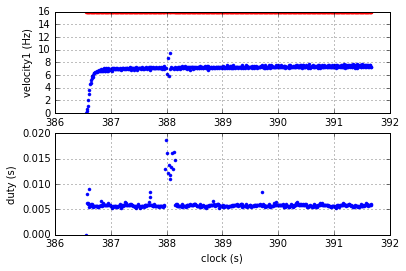

In [17]:
clock = log[:,0]
encoder1 = log[:,1]
velocity1 = log[:,2]
motor1 = log[:,3]
reference1 = log[:,4]
duty = log[:,5]

fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(clock, velocity1, '.b', clock, reference1, '.r')
# the next lines will make the plot look nicer
plt.xlabel('clock (s)')
plt.ylabel('velocity1 (Hz)')
plt.grid()

plt.subplot(2,1,2)
plt.plot(clock, duty, '.')
# the next lines will make the plot look nicer
plt.xlabel('clock (s)')
plt.ylabel('duty (s)')
plt.grid()

In [18]:
ind, = np.where(clock > clock[0] + 2)
vmean = np.mean(velocity1[ind[0]:])
vstd = np.std(velocity1[ind[0]:])
print('mean = {:5.3f}, standard deviation = {:5.3f}'.format(vmean,vstd))

mean = 7.322, standard deviation = 0.142


**TASKS:**
1. Repeat the above steps with a proportional gain `Kp` equal to 2 then 4

**QUESTIONS:**
1. How does the ratio between the average velocity and the reference velocity vary with `Kp`?

In [ ]:
# YOUR SOLUTION HERE

## Open- and Closed-loop Gains

In order to understand why the achieved velocity is not equal to the reference velocity it is convinient to think of each block of the control-loop as a simple *static gain*. That is, the motor is simply

$$
    \text{velocity} = G \, \text{control}
$$

where $G$ is the **open-loop gain**, and the controller:

$$
    \text{control} = K \, \text{error}
$$

Recalling that 

$$
\text{error} = \text{reference} - \text{velocity} = \text{reference} - \text{velocity}
$$

you will show that:

$$
\begin{aligned}
\text{velocity} &= H \, \text{reference}, & H &= \frac{K G}{1 + K G}
\end{aligned}
$$

The quantity $H$ is the **closed-loop gain**.

**TASKS:**
1. Use the above formula to compare the ratio between the average velocity and the reference velocity with what you obtained experimentally

**QUESTIONS:**
1. How can you compute the open-loop gain, $G$?
2. Why did we set `K = Kp / G`?
3. What value of `Kp` would make the closed loop gain, $H$, become close to 1?
4. What is the effect of errors in open-loop gain, $G$, in the value of the closed-loop gain, $H$?
5. Prove the closed-loop gain formula. *Hint: substitute for control and error and solve for velocity in the above equations*

In [ ]:
# YOUR SOLUTION HERE

## Regulation and Instability

**TASKS:**
1. Run the following code to implement a closed-loop proportional velocity controller this time with a reference velocity equal to 0: this is a **regulator**
2. Try to turn the pulley when the controller is on
3. Repeat with `Kp` equal to 2, 4, and 16
4. Repeat with `Kp` equal to -1, -2, and -4

**QUESTION:**
1. What difference does the gain make?
2. Name an application for this velocity regulator
3. What does the regulator do when the gain `Kp` is negative?
4. What happens when the gain `Kp` is positive and large?
5. What happens when the gain `Kp` is negative and large?

## Position Control

The principles of feedback control are abstract and apply to a variety of systems. For example, we could use a similar scheme:

<img src="figure5.png" width="650">

if we wish to control the **position** of rotor of the DC motor, instead of its velocity,

In this case **proportional control** is:

$$
\begin{aligned}
  \text{control} &= K \, \text{error}, & \text{error} &= \text{reference} - \text{position}
\end{aligned}
$$

which produces input which is *proportional* to the error, this time computed with respect to position. From a practical standpoint all that is needed is a new sensor to measure position, which we already have.

**TASKS:**
1. Run the following code to implement a proportional position controller
2. Import the data and plot time *vs* position, time *vs* reference and control and time *vs* velocity
3. Repeat the above steps with a proportional gain `Kp` equal to 2 then 4

**QUESTIONS:**
1. Compare the responses in the case of position control with that of velocity control
2. Contrast the control signal in both cases
3. Is position related to the control signal by a gain?
4. How could you calculate the closed-loop gain in the case of position control?

In [ ]:
a = 0.25
G = a
Kp = 1

K = Kp/G

device.add_signal('reference1')
device.add_filter('controller1', 
                  Feedback(block = Gain(gain = K)),
                  ['encoder1', 'reference1'], 
                  ['motor1'])
device.add_sink('logger', Logger(auto_reset=True),['clock', 'encoder1', 'velocity1', 'motor1', 'reference1','duty'])
print(device.info('all'))

In [ ]:
device.set_source('encoder1', reset=True)
with device:
    device.set_signal('reference1', 20)
    time.sleep(5)
log = device.read_sink('logger')

In [ ]:
clock = log[:,0]
encoder1 = log[:,1]
velocity1 = log[:,2]
motor1 = log[:,3]
reference1 = log[:,4]

plt.plot(clock, encoder1, '.b', clock, reference1, '.r')
# the next lines will make the plot look nicer
plt.xlabel('clock (s)')
plt.ylabel('encoder1 (Hz)')
plt.grid()

## Integral Velocity Control

One problem when using a proportional controller to control the velocity of the DC motor is that the velocity does not actually **track** the reference: there is always a need for some error to exist so that the motor can continue to run. **Integral Control** is one way to overcome this problem.

You might have noticed when controlling the position of the motor that the final position was always close to the reference position, even when relatively small gains where used. This is because the motor produces a constant velocity in response to a constant control voltage. No control voltage must exist for the position error to be zero! The reason for this is that the position is the **integral** of the velocity. You might want to think of the integral of the velocity as the area below the velocity in the velocity *vs* time curve.

We can bring this idea to the velocity controller. In addition to a proportional control term we have an **integrator** that *accumulates* the error signal, as represented by the block-diagram:

<img src="figure6.png" width="650">

In the presence of a positive error signal the output of the integrator continues to grow. When the error is zeroed, the integrator stops acumulating but holds a constant control output that will offset the system in the desired way. The resulting controller is called a **proportional-integral-controller**, or simply **PI-controller**. 

With integral control it is possible to **track constant references** while keeping the gains small. Integral control is the most widely use form of control algorithm and can be found, for instance in your vehicle's cruise control.

**TASKS:**
1. Run the following code to implement a proportional-integral velocity controller
2. Import the data and plot time vs velocity and time vs reference and control
3. Discard the first second of data and use `np.mean` and `np.std` to calculate the average and standard deviation of the velocity
4. Calculate the ratio between the average velocity and the reference velocity
5. Have a group mate touch the top of the big pulley with his or her finger and apply a gentle force trying to stop the motor. Make sure the force does not completely stop the motor, as this may damage the motor
6. Repeat the above steps with a integral gain `Ki` equal to 0.1, 1, and 10

**QUESTIONS:**
1. Did the closed-loop controller achieve the reference velocity?
2. What happened when your group mate disturbed the pulley?
3. What happened to the control as your group mate disturbed the pulley?
4. Can you name processes in your body that are regulated  like that?
5. What is the effect of a small integral gain?
6. What is the effect of a large integral gain?

In [19]:
a = 0.25
G = a
Kp = 1
Ki = 10
Ts = 0.01

K = Kp/G

device.add_signal('reference1')
device.add_filter('controller1', 
                  Feedback(block = SISO(model = PID(Kp = K, Ki = Ki/G, period = Ts))),
                  ['velocity1', 'reference1'], 
                  ['motor1'])
device.add_sink('logger', Logger(auto_reset=True),['clock', 'encoder1', 'velocity1', 'motor1', 'reference1','duty'])
print(device.info('all'))

> Controller with 4 device(s), 8 signal(s), 3 source(s), 2 sink(s), and 2 filter(s)
> devices
  1. encoder1[source]
  2. motor1[sink]
  3. analog1[source]
  4. clock[source]
> signals
  1. analog1
  2. clock
  3. duty
  4. encoder1
  5. is_running
  6. motor1
  7. reference1
  8. velocity1
> sources
  1. clock[Clock, enabled] >> clock
  2. encoder1[Encoder, enabled] >> encoder1
  3. analog1[Analog, enabled] >> analog1
> filters
  1. clock, encoder1 >> velocity1[Differentiator, enabled] >> velocity1
  2. velocity1, reference1 >> controller1[Feedback, enabled] >> motor1
> sinks
  1. motor1 >> motor1[Motor, disabled]
  2. clock, encoder1, velocity1, motor1, reference1, duty >> logger[Logger, enabled]



In [28]:
with device:
    device.set_signal('reference1', 16)
    time.sleep(30)
log = device.read_sink('logger')

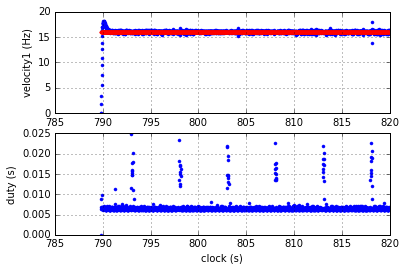

In [29]:
clock = log[:,0]
encoder1 = log[:,1]
velocity1 = log[:,2]
motor1 = log[:,3]
reference1 = log[:,4]
duty = log[:,5]

fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(clock, velocity1, '.b', clock, reference1, '.r')
# the next lines will make the plot look nicer
plt.xlabel('clock (s)')
plt.ylabel('velocity1 (Hz)')
plt.grid()

plt.subplot(2,1,2)
plt.plot(clock, duty, '.')
# the next lines will make the plot look nicer
plt.xlabel('clock (s)')
plt.ylabel('duty (s)')
plt.grid()

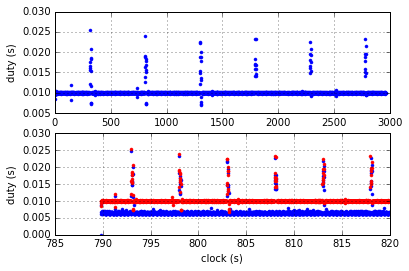

In [30]:
dclock=clock[1:]-clock[:-1]

plt.subplot(2,1,1)
plt.plot(dclock, '.')
# the next lines will make the plot look nicer
plt.xlabel('clock (s)')
plt.ylabel('duty (s)')
plt.grid()

plt.subplot(2,1,2)
plt.plot(clock, duty, '.b', clock[:-1], dclock, '.r')
# the next lines will make the plot look nicer
plt.xlabel('clock (s)')
plt.ylabel('duty (s)')
plt.grid()

In [31]:
ind, = np.where(clock > clock[0] + 2)
vmean = np.mean(velocity1[ind[0]:])
vstd = np.std(velocity1[ind[0]:])
print('mean = {:5.3f}, standard deviation = {:5.3f}'.format(vmean,vstd))

mean = 16.006, standard deviation = 0.174
